# Description 

This is an exploratory notebook to test out different pre-trained Keras models for image processing. We will be using the models to predict image features, and then comparing features between images using cosine similarity. 

Images with the highest cosine similarity scores will be generated as recommendations.

Keywords: Keras, Tensorflow, transfer learning, image recognition, recommender systems.


In [67]:
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

# 1. Loading Pre-trained Keras Image Models



In [68]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

from tqdm import tqdm
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt


from keras.models import Model
from keras.preprocessing.image import load_img,img_to_array
from keras.applications import (vgg16,  vgg19, xception, 
                                inception_v3,  inception_resnet_v2, 
                                mobilenet,densenet, nasnet, mobilenet_v2)
vgg16_model = vgg16.VGG16(weights='imagenet')
# vgg19_model = vgg19.VGG19(weights='imagenet')
# mobv2= mobilenet_v2.MobileNetV2(input_shape=None, alpha=1.0, 
#                                        include_top=True, 
#                                        weights='imagenet')
# nasnetmobile = nasnet.NASNetMobile(weights="imagenet")
# largest_dense_net = densenet.DenseNet201(weights="imagenet")
# mobilenet_ = mobilenet.MobileNet(weights="imagenet")
# incepv2 = inception_resnet_v2.InceptionResNetV2(include_top=True, weights='imagenet', 
#                                                 input_tensor=None, input_shape=None, pooling=None, classes=1000)
# incepv3 = inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, 
#                                    input_shape=None, pooling=None, classes=1000)
# Xception_ = xception.Xception(include_top=True, weights='imagenet', input_tensor=None, 
#                               input_shape=None, pooling=None, classes=1000)
# large_nasnet = nasnet.NASNetLarge(input_shape=None, include_top=True, weights='imagenet', 
#                                   input_tensor=None, pooling=None, classes=1000)

# 2. Cleaning an image dataset

Given a dataset of PNGs:
 - we need to resize each image
 - We need to convert each image to a 3-dimensional matrix
 - Pre-process the matrix using Keras built-in functions


In [69]:
images_directory = '/content/images/'

In [72]:
class ImageRecommenderSystem : 
    
    def __init__(self, model, list_of_images, filespath='/content/images/') : 
        self.model = model
        self.filespath = filespath
        self.list_of_images = list_of_images

        # Since ouput.shape returns object dimension, just eval it to get integer ...
        self.image_width = eval(str(self.model.layers[0].output.shape[1]))
        self.image_height = eval(str(self.model.layers[0].output.shape[2]))
        
        # Remove the last layers in order to get features instead of predictions
        self.image_features_extractor = Model(inputs=self.model.input, outputs=self.model.layers[-2].output)
        self.processed_image = self.image_to_matrix()
        self.sim_table = self.get_similarities(self.processed_image)
        
    def load_image(self, image_url) :
        try : 
            pil_image = load_img(self.filespath + image_url, target_size=(self.image_width, self.image_height))
            return pil_image
        except OSError : 
            # image unreadable, remove from list
            self.list_of_images = [x for x in self.list_of_images if x != image_url]
            #self.list_of_images.remove(image_url)
            pass
        
    def image_to_matrix(self) :
        """
        # convert the PIL image to a numpy array
        # in PIL - image is in (width, height, channel)
        # in Numpy - image is in (height, width, channel)
        # convert the image / images into batch format
        # expand_dims will add an extra dimension to the data at a particular axis
        # we want the input matrix to the network to be of the form (batchsize, height, width, channels)
        # thus we add the extra dimension to the axis 0.
        """
        #from keras.preprocessing.image import load_img,img_to_array
        list_of_expanded_array = list()

        for i in self.list_of_images:
          tmp = img_to_array(self.load_image(i))
          expand = np.expand_dims(tmp, axis = 0)
          list_of_expanded_array.append(expand)

        images = np.vstack(list_of_expanded_array)
        
        return preprocess_input(images)
    
    def get_similarities(self, processed_imgs) :
        print('============ Similarity Prediction =========')
        imgs_features = self.image_features_extractor.predict(processed_imgs)
        print(f"Given image has {imgs_features.size} features:")
        cosine_similarity_scores = cosine_similarity(imgs_features)
        cos_similarities_df = pd.DataFrame(cosine_similarity_scores, columns=self.list_of_images[:len(self.list_of_images)], index=self.list_of_images[:len(self.list_of_images)])
        return cos_similarities_df
    
    def most_similar_to(self, given_img, num_similar_images = 5):

        print("-----------------------------------------------------------------------")
        print("Original image:")

        original = self.load_image(given_img)
        plt.imshow(original)
        plt.show()

        print("-----------------------------------------------------------------------")
        print("Most similar image:")

        closest_imgs = self.sim_table[given_img].sort_values(axis=0, ascending=False)[1:num_similar_images+1].index
        closest_imgs_scores = self.sim_table[given_img].sort_values(ascending=False)[1:num_similar_images+1]

        for i in range(0,len(closest_imgs)):
            original = self.load_image(closest_imgs[i])
            plt.imshow(original)
            plt.show()
            print("similarity score : ",closest_imgs_scores[i])

length of files is  100
Pre-trained model(s) "[<keras.engine.functional.Functional object at 0x7f3e5f7c6250>]" is running
============ Similarity Prediction =========
Given image has 409600 features:
Most similar to 1565.jpg
-----------------------------------------------------------------------
Original image:


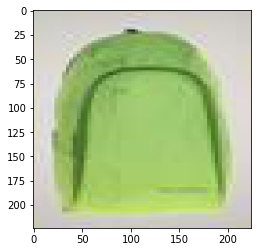

-----------------------------------------------------------------------
Most similar image:


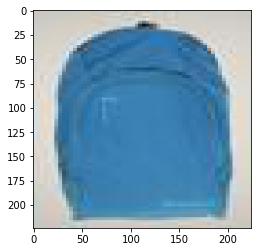

similarity score :  0.6972569


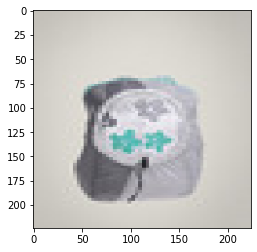

similarity score :  0.5980222


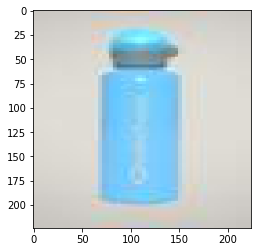

similarity score :  0.56686753


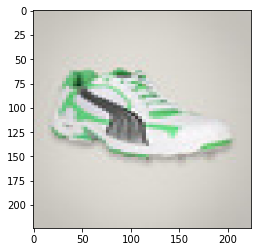

similarity score :  0.5632123


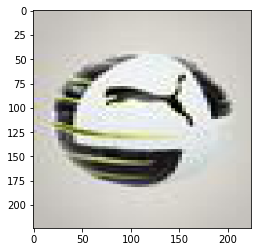

similarity score :  0.54393685
Most similar to 1571.jpg
-----------------------------------------------------------------------
Original image:


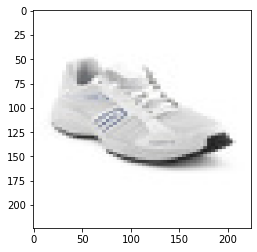

-----------------------------------------------------------------------
Most similar image:


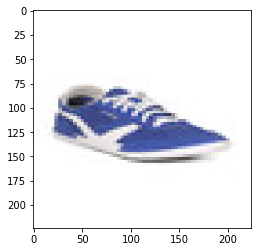

similarity score :  0.79964936


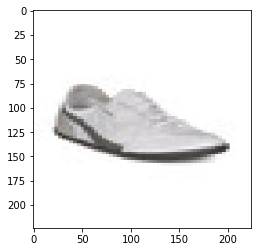

similarity score :  0.7627034


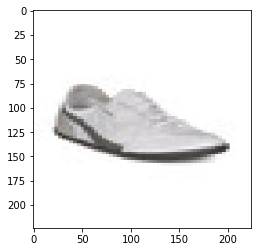

similarity score :  0.7627034


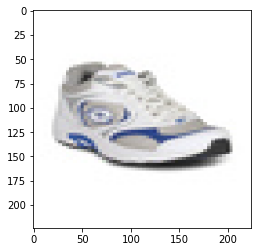

similarity score :  0.76088357


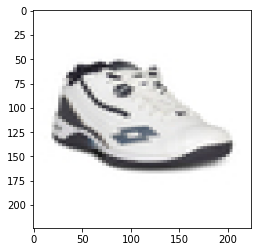

similarity score :  0.74363023
Next model ...




In [73]:
list_of_pretrained = [vgg16_model]
files = [x for x in os.listdir("/content/images") if x.endswith('jpg')]
files = np.random.choice(files, 100)

print('length of files is ', len(files))

for pretrained_model in list_of_pretrained : 
    print('=========================================')
    print(f'Pre-trained model(s) "{list_of_pretrained}" is running')
    print('=========================================')
    pretrained_recommender = ImageRecommenderSystem(pretrained_model, files, filespath = '/content/images/')

    print(f'Most similar to {files[0]}')
    print('=========================================')
    pretrained_recommender.most_similar_to(files[0])

    print(f'Most similar to {files[10]}')
    print('=========================================')
    pretrained_recommender.most_similar_to(files[10])

    print('Next model ...')
    print('\n')


# References:
    1. AlexWarembourg - https://towardsdatascience.com/image-recommendation-engine-leverage-transfert-learning-ec9af32f5239
 